# *Pneumonia Detection on Chest Radiographs using Deep Learning Techniques*

# *Overview*

Pneumonia is an infection in one or both lungs. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

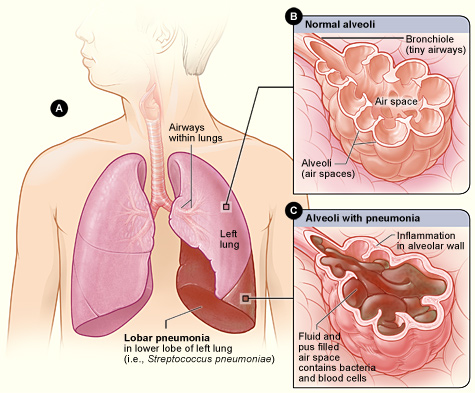

Physicians or radiologists perform a physical examination and employ a chest x-ray (CXR) to evaluate and identify pneumonia. The CXR reveals opacity in the affected area.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm).
So our initial steps involve examining the DICOM data, extracting metadata from the DICOM files, and visualizing the different characteristics of the DICOM images, categorized according to age and sex.

## *Installing required packages and libraries*

In [8]:
!pip install matplotlib
!pip install pandas
!pip install pydicom

     ---------------------------------------- 2.0/2.0 MB 4.0 MB/s eta 0:00:00


In [3]:
from matplotlib import pyplot as plt

In [4]:
import glob, pandas as pd
import matplotlib.pyplot as plt
import pydicom, numpy as np

In [5]:
#To parse the data
def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': "D:\\Pneumonia_Set_Project\\stage_2_train_images\\%s.dcm" % pid,
                'label': row['Target'],
                'boxes': []}

        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

Reading the data from our csv files
1. stage_2_train.csv - the training set. Contains patientIds and bounding box / target information.
2. stage_2_detailed_class_info.csv - provides detailed information about the type of positive or negative class for each image.

In [6]:
df = pd.read_csv("D:\\Pneumonia_Set_Project\\stage_2_train_labels.csv")

patient_class = pd.read_csv("D:\\Pneumonia_Set_Project\\stage_2_detailed_class_info.csv", index_col=0)

parsed = parse_data(df)

patientId = df['patientId'][0]
print(parsed[patientId])
print(patient_class.loc[patientId])

{'dicom': 'D:\\Pneumonia_Set_Project\\stage_2_train_images\\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
class    No Lung Opacity / Not Normal
Name: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, dtype: object


The above shows that for the first patient, there are no lung opacity and we didn't get any bounding boxes

In [7]:
df.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

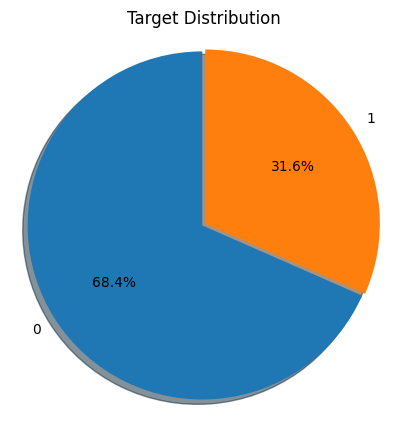

In [33]:
label_count = df['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

We can see that label '0' is more in number, so before splitting into train-test we need to stratify the data or use some sampling techniques to avoid bias

From the above dataframe, we can see that only for those having Target value as 1, meaning they have pneumonia we have bounding boxes

### *Exploring Patient Class*

In [16]:
patient_class.head()

class
patientId                                                         
0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [17]:
print("Number of classes in the dataset :: %i" %  len(patient_class["class"].unique()))
print("Classes' names are :: %s" % patient_class["class"].unique())

Number of classes in the dataset :: 3
Classes' names are :: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


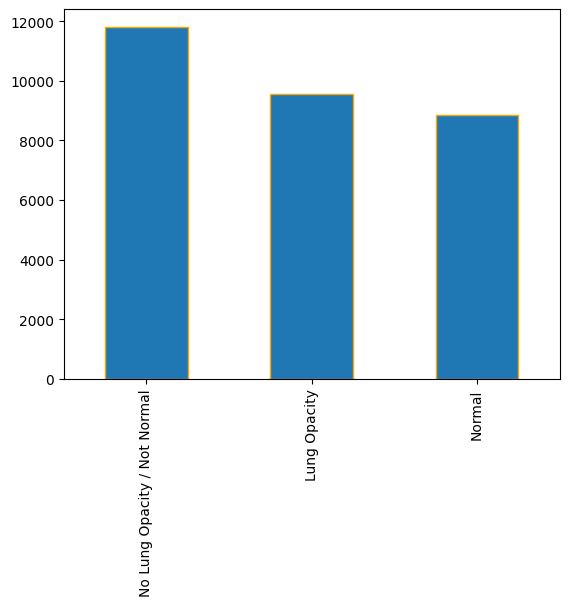

In [18]:
class_count = patient_class['class'].value_counts()
class_count.plot.bar( ec="orange")
print(class_count)

### *Exploring Patient Details*

In [19]:
patientIds = df.drop_duplicates('patientId', keep = 'first').patientId.tolist()

In [20]:
Sex = []
Age = []
for patientId in patientIds:
    dcm_file = 'D:\\Pneumonia_Set_Project\\stage_2_train_images\\%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    Sex.append(dcm_data.PatientSex)
    Age.append(int(dcm_data.PatientAge))

In [23]:
patientInfo = pd.DataFrame({'patientId': patientIds, 'patientSex': Sex, 'patientAge': Age})
patientInfo.dtypes

patientId     object
patientSex    object
patientAge     int64
dtype: object

In [24]:
patientAge_count = patientInfo['patientAge'].value_counts().sum()
patientSex_count = patientInfo['patientSex'].value_counts().sum()
patient_count = patientInfo['patientId'].value_counts().sum()

print("total number of patientId :: %i" % patient_count )
print("Total number of patients with Non null patientSex :: %i " % patientSex_count )
print("Total number of patients with Non null patientAge :: %i " %  patientAge_count )
print("Number of missing values to be imputed for the first field :: %i " % (patient_count - patientSex_count) )
print("Number of missing values to be imputed for the second field :: %i " % (patient_count - patientAge_count) )

total number of patientId :: 26684
Total number of patients with Non null patientSex :: 26684 
Total number of patients with Non null patientAge :: 26684 
Number of missing values to be imputed for the first field :: 0 
Number of missing values to be imputed for the second field :: 0 


In [26]:
patientInfo = patientInfo.set_index('patientId').join(df.set_index('patientId'))[['patientSex', 'patientAge', 'Target']]
patientInfo.reset_index(inplace=True)
patientInfo.head()

patientId patientSex  patientAge  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6          F          51       0
1  000924cf-0f8d-42bd-9158-1af53881a557          F          19       0
2  000db696-cf54-4385-b10b-6b16fbb3f985          F          25       1
3  000db696-cf54-4385-b10b-6b16fbb3f985          F          25       1
4  000fe35a-2649-43d4-b027-e67796d412e0          M          40       1

In [27]:
patientInfo.describe()

patientAge        Target
count  30227.000000  30227.000000
mean      46.797764      0.316108
std       16.892940      0.464963
min        1.000000      0.000000
25%       34.000000      0.000000
50%       49.000000      0.000000
75%       59.000000      1.000000
max      155.000000      1.000000

Exploring Age of patients

<Axes: >

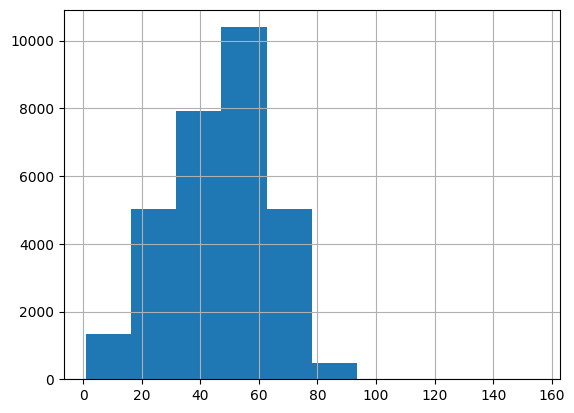

In [28]:
patientInfo['patientAge'].hist()

In [29]:
patientInfo[patientInfo['patientAge']>=85]['patientAge'].value_counts()

86     25
87     20
90     19
85     16
88     12
89      8
91      3
92      2
148     1
151     1
153     1
150     1
155     1
Name: patientAge, dtype: int64

We can see that some patient have age more than 100+ and some even ranging to 140+, either these ages are masked or they are some error in data collection

## *Let us visualize the bounding boxes*

In [8]:
#Method to draw single patient with bounding box(es) if present 
def draw(data):
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    # --- Convert coordinates to integers
    box = [int(b) for b in box]

    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

### 1. *Visualizing a  normal chest radiograph without any opacities*

class    Normal
Name: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, dtype: object


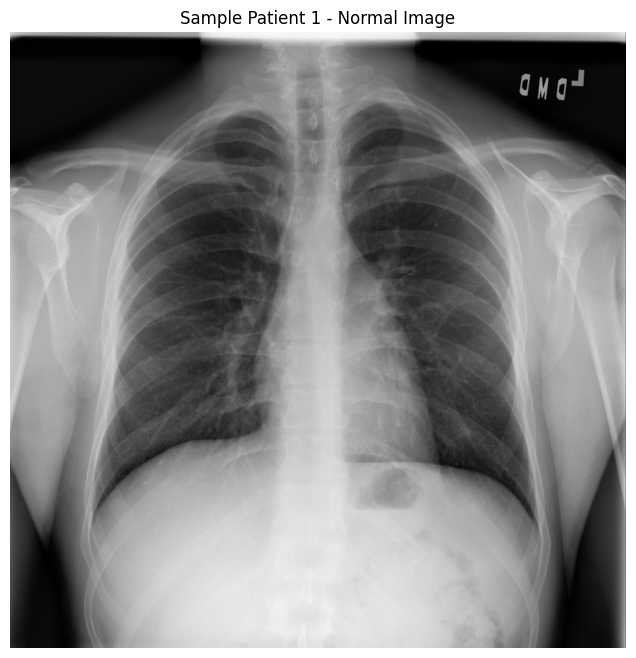

In [9]:
patientId = df['patientId'][3]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 1 - Normal Image")

draw(parsed[patientId])

### 2. *Visualizing a Normal Image having opacities*

                                             class
patientId                                         
00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity


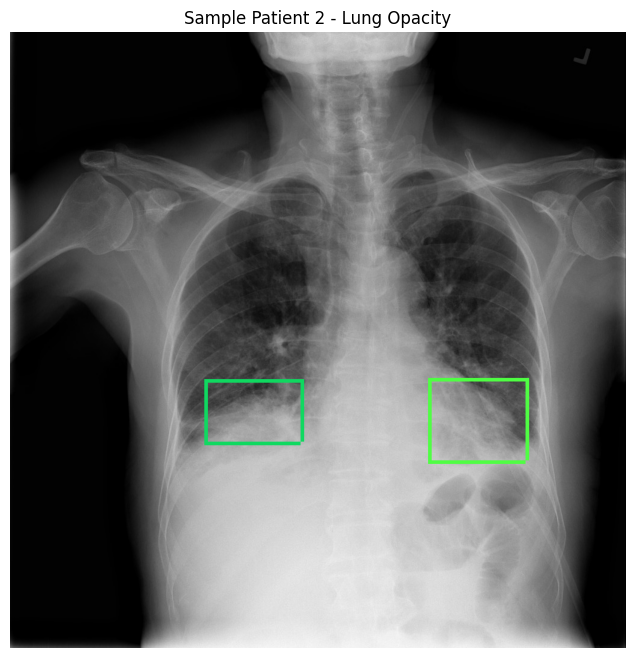

In [10]:
patientId = df['patientId'][8]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 2 - Lung Opacity")

draw(parsed[patientId])

Let us understand the difference between the two pictures and understand what we mean by opacity

Here, in Chest Radiographs :-
* Black = Air
* White = Bone
* Grey = Tissue or Fluid

One thing we should keep in mind is that the left side of the subject is on the right side of the screen by convention.

If any region of the chest X-ray appears whiter than expected, it may indicate an abnormality. Comparing the X-ray images of Sample Patient 1 and Sample Patient 2 reveals that patient 2's lower lung boundary is obstructed by opacities. In Sample Patient 1's X-ray image, a clear distinction can be seen between the black lungs and the tissue beneath, while in Sample Patient 2's image, there is only a blurry appearance.

Usually the lungs are full of air. When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. 

### *To get a better understanding, let us compare few images side by side*

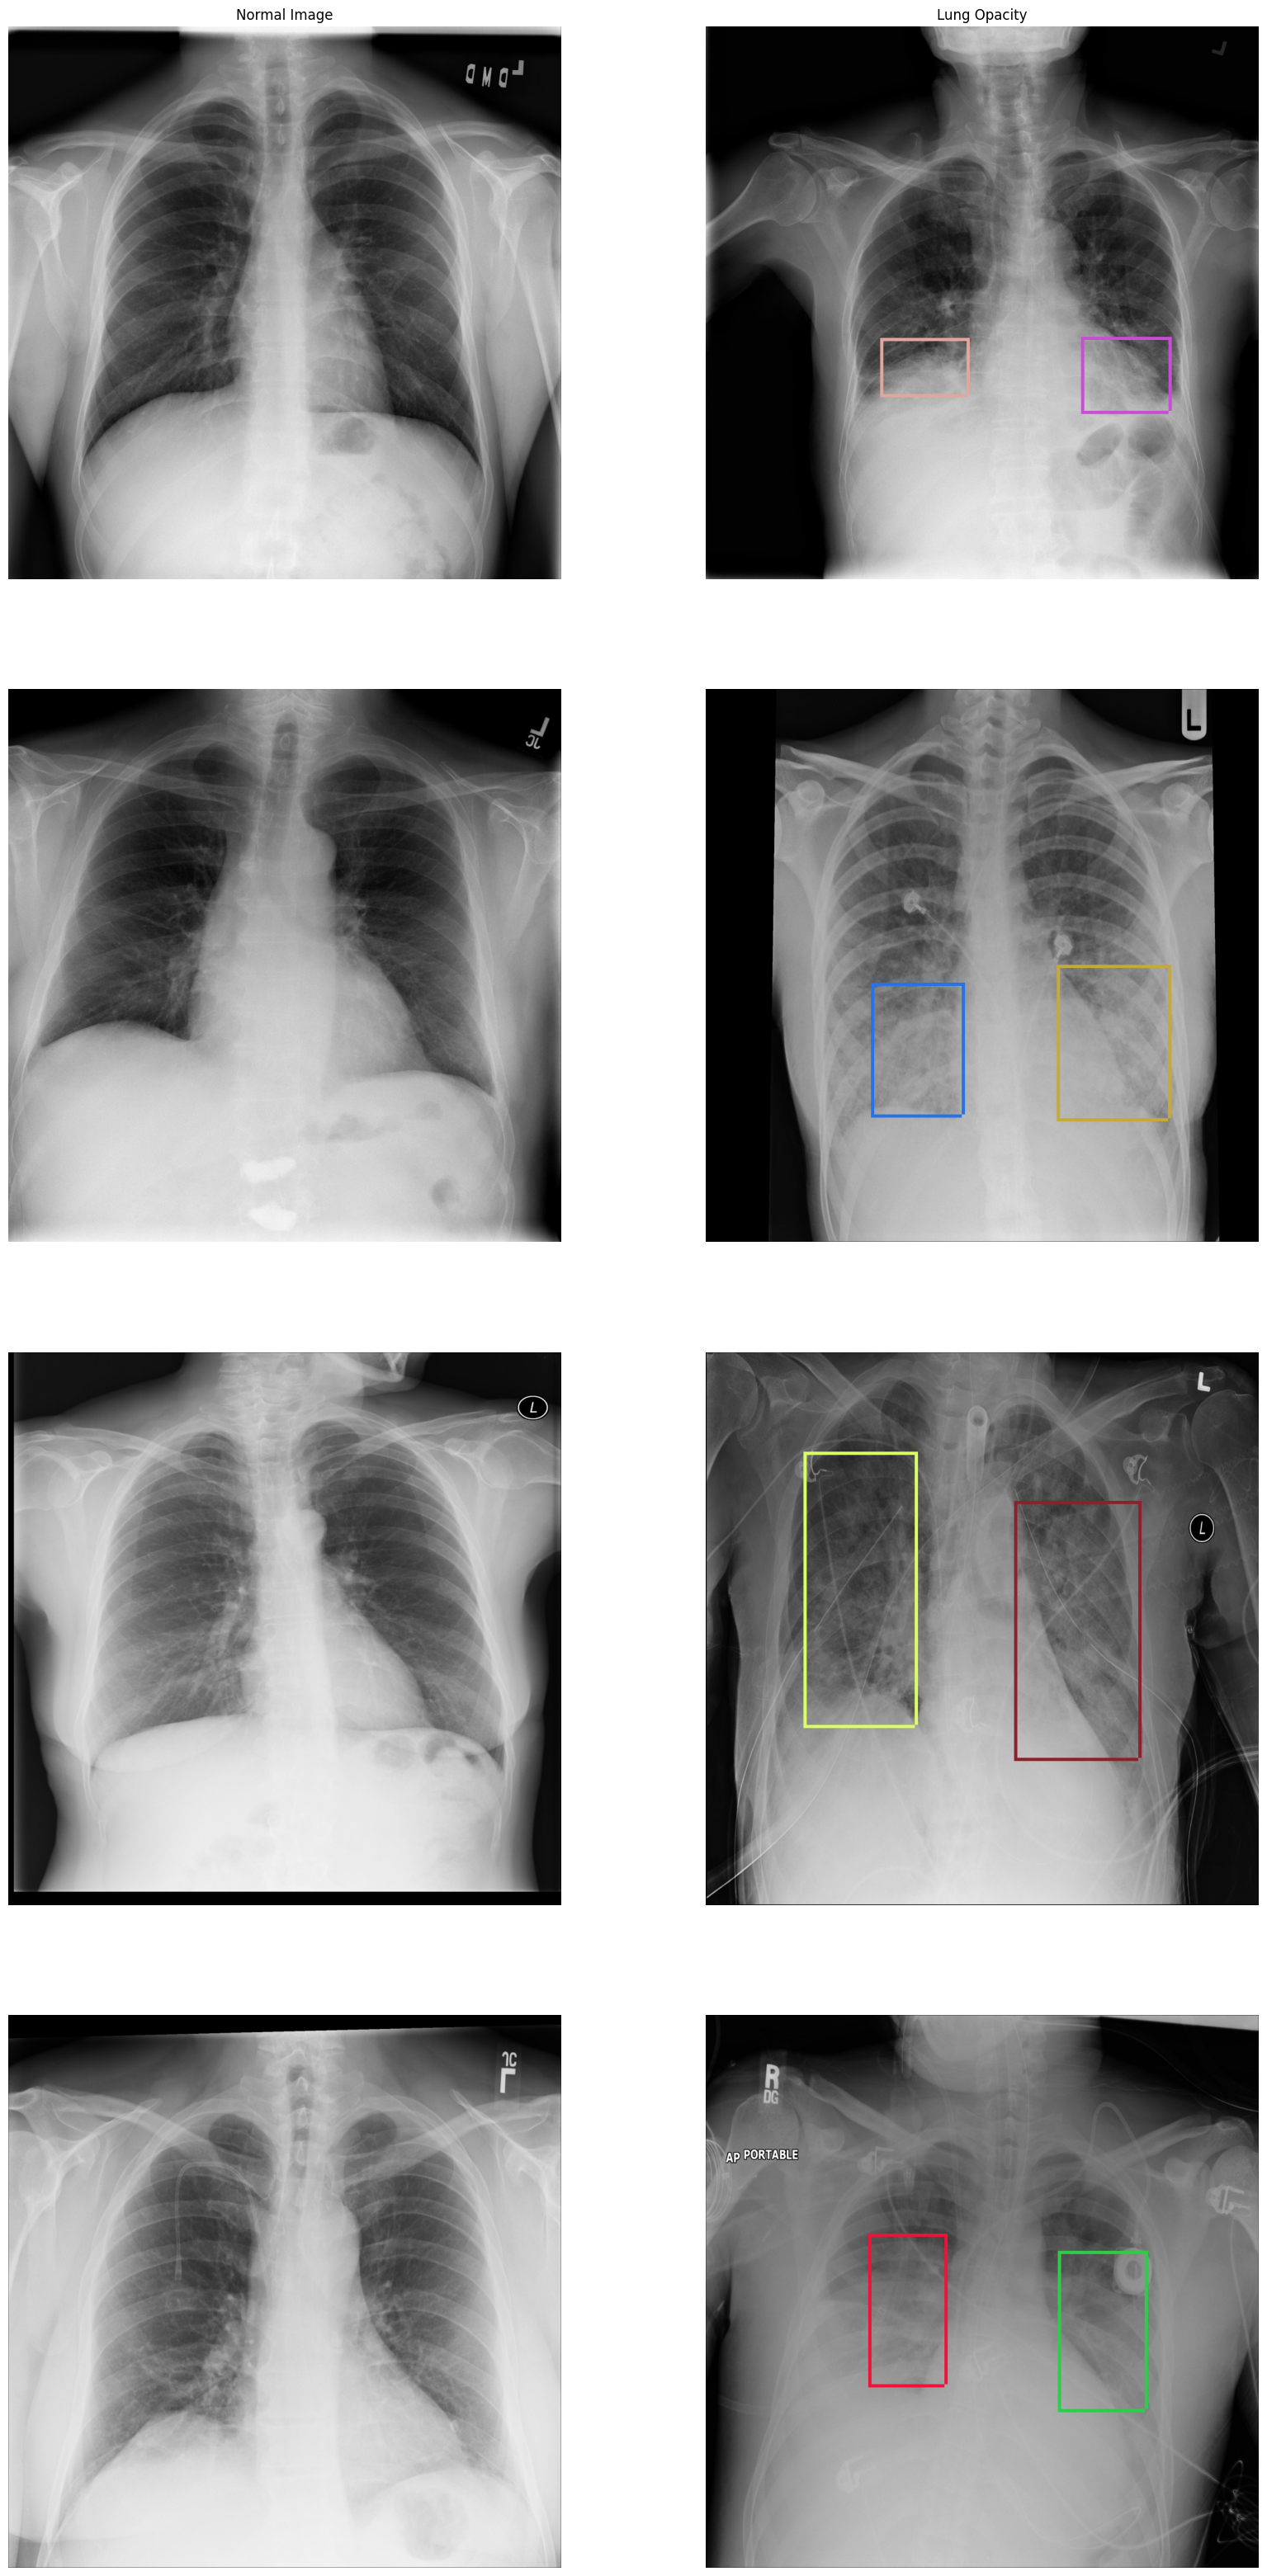

In [11]:
plt.figure(figsize=(20, 40))

plt.subplot(421)
plt.title("Normal Image")

draw(parsed[df['patientId'][3]])

plt.subplot(423)
draw(parsed[df['patientId'][11]])

plt.subplot(425)
draw(parsed[df['patientId'][12]])

plt.subplot(427)
draw(parsed[df['patientId'][13]])

plt.subplot(422)
plt.title("Lung Opacity")

draw(parsed[df['patientId'][8]])

plt.subplot(424)
draw(parsed[df['patientId'][16]])

plt.subplot(426)
draw(parsed[df['patientId'][19]])

plt.subplot(428)
draw(parsed[df['patientId'][24]])

### *We also have one more class i.e No Lung Opacity but also not normal*

class    No Lung Opacity / Not Normal
Name: 00322d4d-1c29-4943-afc9-b6754be640eb, dtype: object


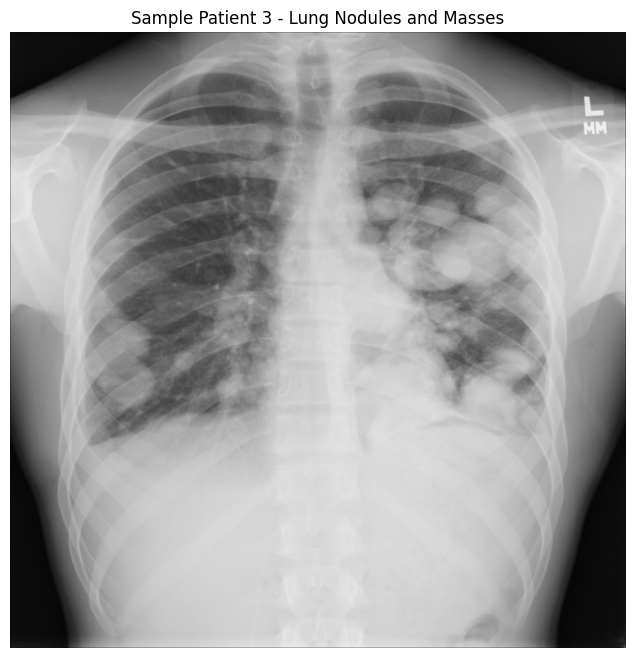

In [12]:
patientId = df['patientId'][2]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw(parsed[patientId])

This is an interesting observation we can see that this patient has a "Target" value of 0 in the "stage_2_train_labels.csv" file, which means he does not have a diagnosis of peumonia.

### *Let us visualize both of these*

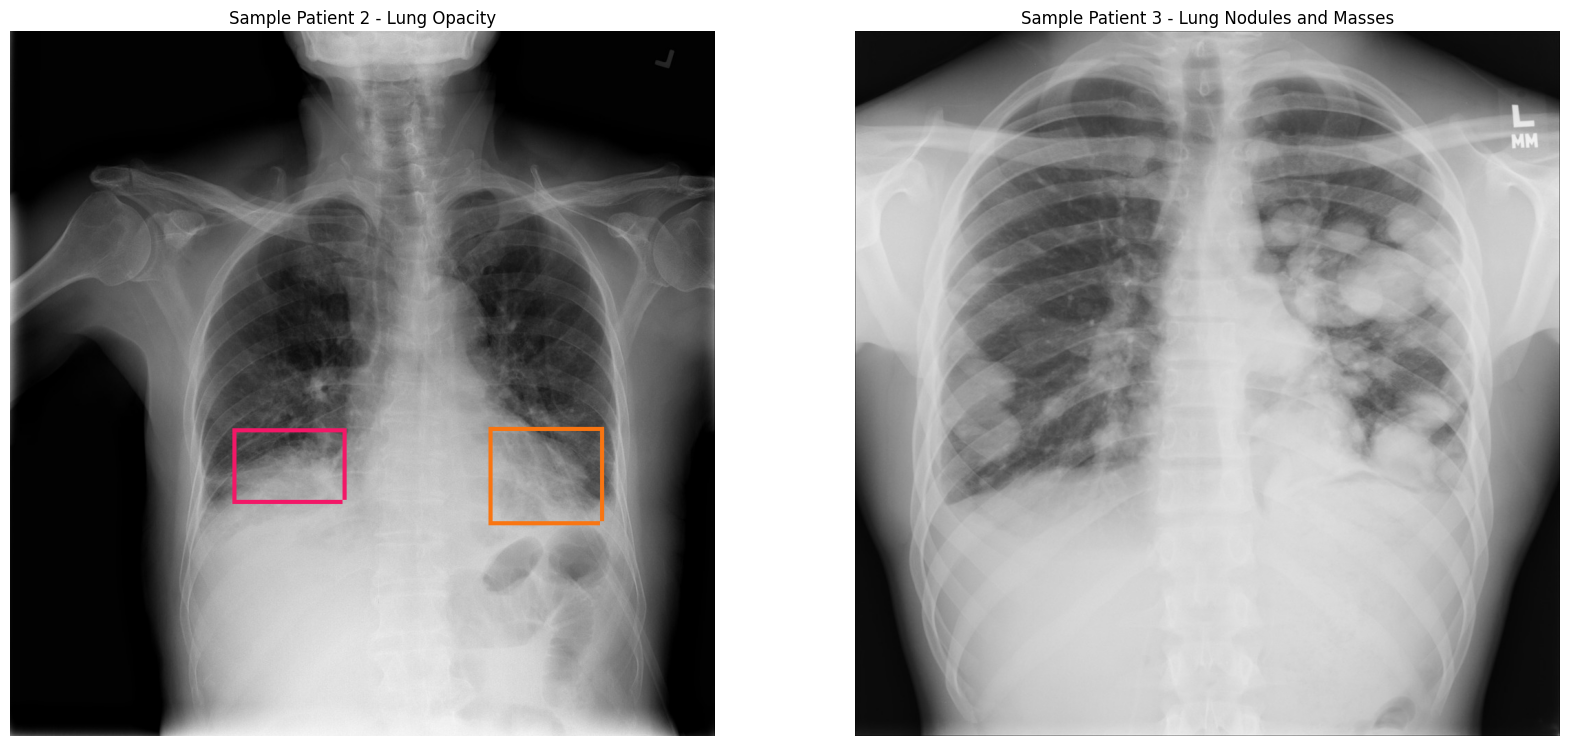

In [13]:
plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 2 - Lung Opacity")
draw(parsed[df['patientId'][8]])

plt.subplot(122)
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw(parsed[df['patientId'][2]])

The primary contrast in opacity types between these two patients lies in the appearance and form of the opacities. Patient 3 displays numerous opacities that are circular and well-defined, while Patient 2 exhibits indistinct haziness that obscures the borders of the lungs and heart.

### Let us take a look at another two classes i.e Normal and No lung opacity

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    No Lung Opacity / Not Normal
Name: 019e035e-2f82-4c66-a198-57422a27925f, dtype: object


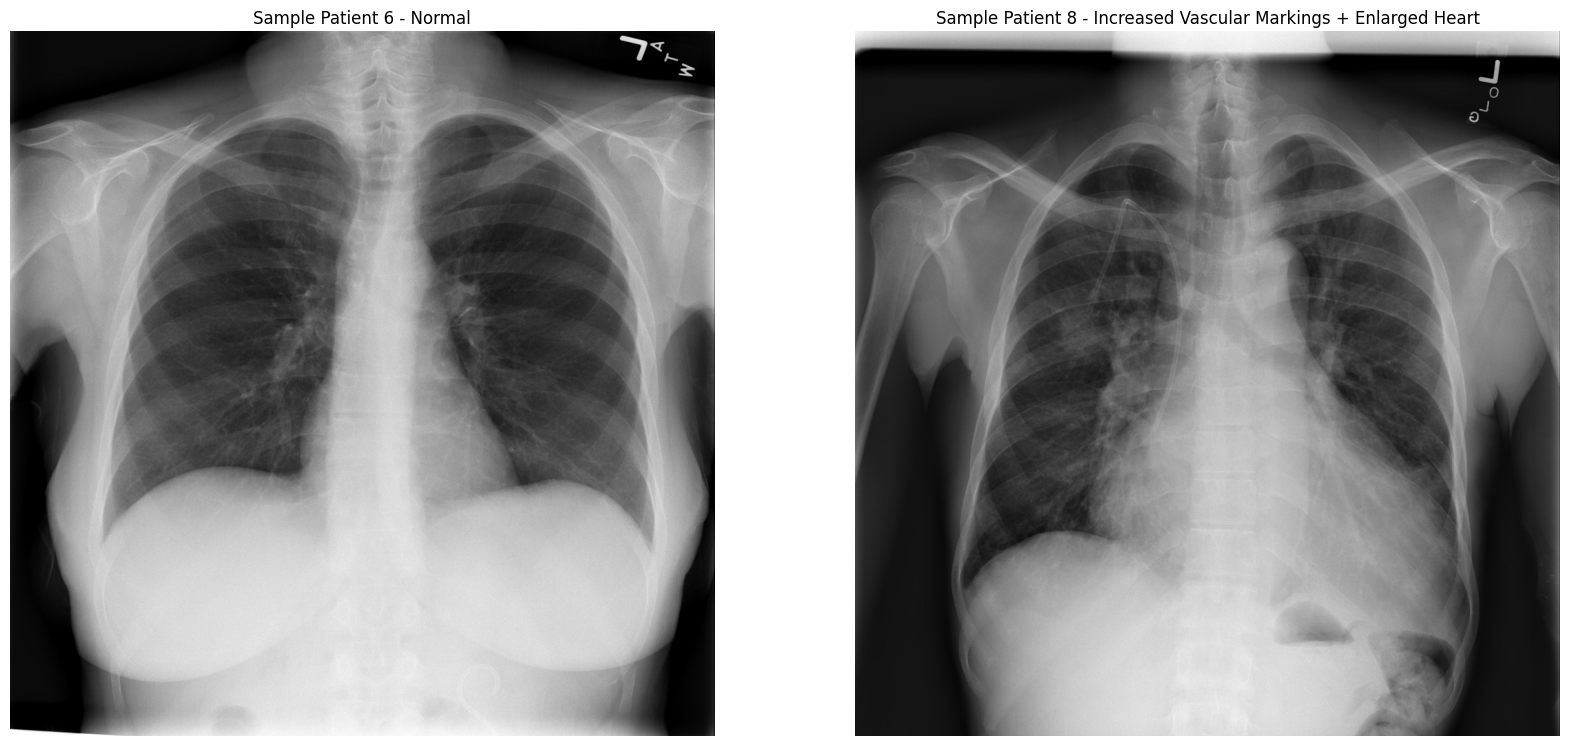

In [14]:
plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 8 - Increased Vascular Markings + Enlarged Heart")
draw(parsed[df['patientId'][38]])
print(patient_class.loc[df['patientId'][38]])

Here, we can observe that Patient 8's heart is occupying an excessive amount of space, exceeding the recommended size of no more than half of the chest cavity.

### *White Lung*

While exploring some of the images, I found that there were radiographs containing white lung and these are labelled as '1' meaning the patient have pneumonia. So the question may arise what happened to the lung if there is no lung, some of the poissibilities are stated as below :-
* The lung was removed in a surgery related to pneumonia
* The lung is filled with fluid from pneumonia
* The lung is there but it is surrounded by fluids inside the chest cavity due to pneumonia thus in the chest radiographs caused white lung

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    Lung Opacity
Name: 924f4f8b-fc27-4dfd-b5ae-59c40715e150, dtype: object
class    Lung Opacity
Name: 17a5ce04-809a-42ed-9e58-100cfb33de7a, dtype: object
class    Lung Opacity
Name: 9dde630b-1f95-46e6-bcde-117eee4c7283, dtype: object


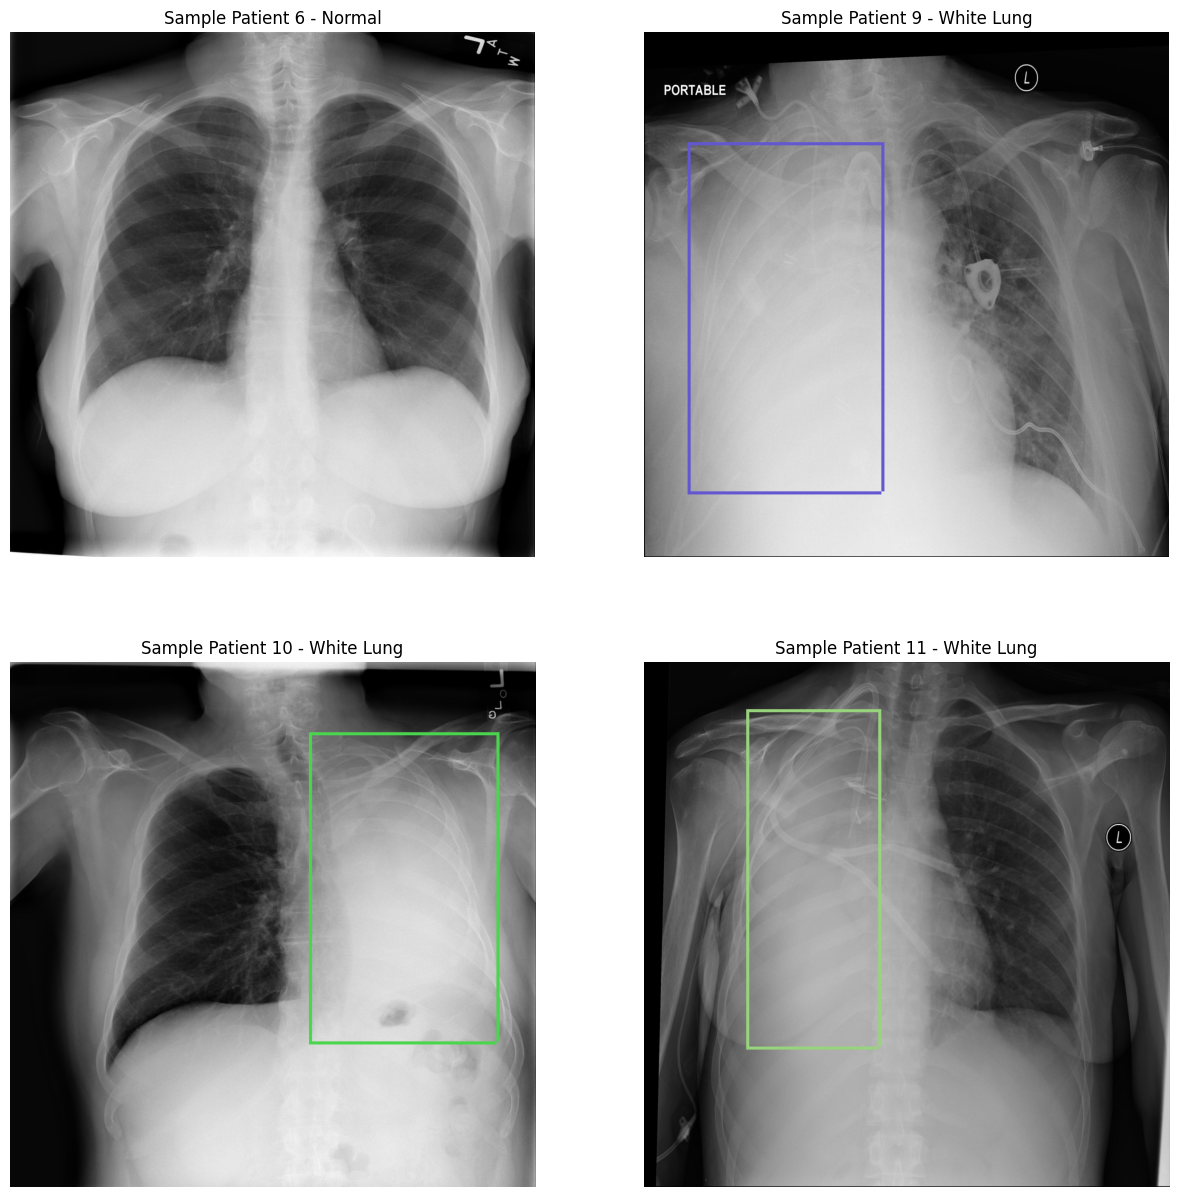

In [15]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(222)
plt.title("Sample Patient 9 - White Lung")
draw(parsed['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])
print(patient_class.loc['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])

plt.subplot(223)
plt.title("Sample Patient 10 - White Lung")
draw(parsed['17a5ce04-809a-42ed-9e58-100cfb33de7a'])
print(patient_class.loc['17a5ce04-809a-42ed-9e58-100cfb33de7a'])

plt.subplot(224)
plt.title("Sample Patient 11 - White Lung")
draw(parsed['9dde630b-1f95-46e6-bcde-117eee4c7283'])
print(patient_class.loc['9dde630b-1f95-46e6-bcde-117eee4c7283'])